# Importation des bibliothèques nécessaires

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os

In [53]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

# Chargement de la base de données
On commence par la création d'une fonction *(get_data)* de préprocessing qui permet de lire et redimensionner les images *par (img_size = 150)* afin de les normaliser et d'optimiser les performances du modèle.

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    X = []
    y = []
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                X.append(resized_arr)
                y.append(class_num)
            except Exception as e:
                print(e)
    return (np.array(X),np.array(y))

In [3]:
X_train, y_train = get_data('./chest_xray/train')
X_test, y_test = get_data('./chest_xray/test')

In [4]:
print('la dimension de X_train est : ', X_train.shape)
print('la dimension de y_train est : ',y_train.shape)
print('la dimension de X_test est : ',X_test.shape)
print('la dimension de y_test est : ',y_test.shape)

la dimension de X_train est :  (5232, 150, 150)
la dimension de y_train est :  (5232,)
la dimension de X_test est :  (624, 150, 150)
la dimension de y_test est :  (624,)


# Visualisation et prétraitement des données

**Aperçu des images des deux classes**

Text(0.5, 1.0, 'NORMAL')

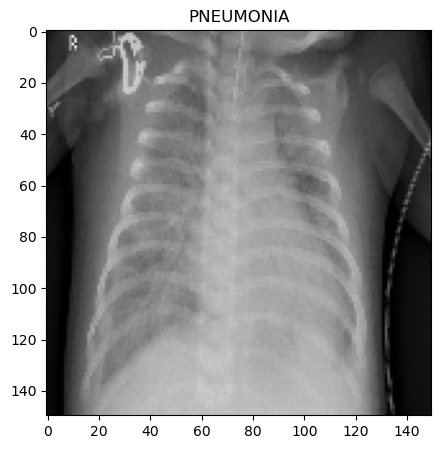

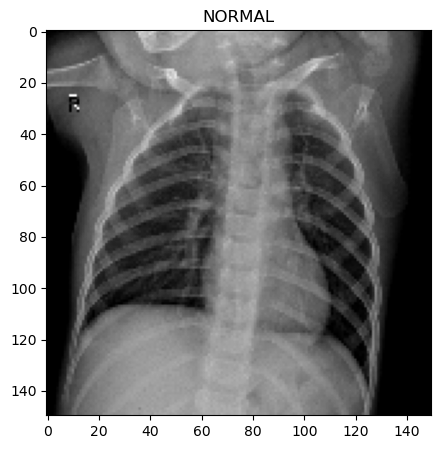

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(X_train[0], cmap='gray')
plt.title(labels[y_train[0]])
                 
plt.figure(figsize = (5,5))
plt.imshow(X_train[-1], cmap='gray')
plt.title(labels[y_train[-1]])

(array([0, 1]), array([3883, 1349], dtype=int64))

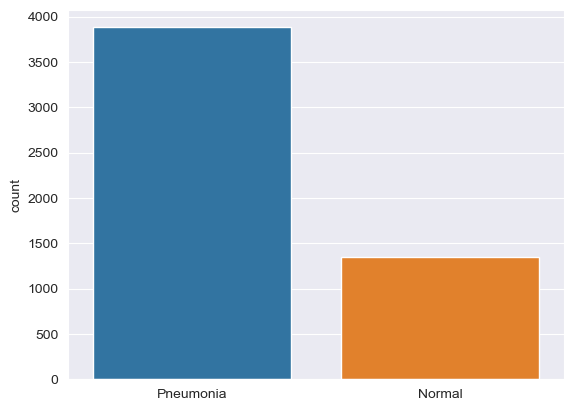

In [8]:
l = []
for i in y_train:
    if i == 0:
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=l)
np.unique(y_train, return_counts=True)

**Les données semblent déséquilibrées car on a 3883 des image de type *Pneumonia* contrairement au type *Normal* on a seulement 1349. Pour faire face à cette phénomène on peut augmenter le nombre d'exemples d'entraînement pour la classe 'Normal', dans cette application nous utiliserons l'augmentation des données. mais il y a d'autres solutions pour cette phénomène à savoir diminuer le nombre d'exemples pour la classe 'Pneumonia' ou affecter des grands poids pour l'autre classe ... .**

In [9]:
# Création d'un générateur de données pour l'augmentation des images
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

Pour cette augmentation des données, j'ai choisi :
1. La rotation aléatoire des images dans une plage de -20 à 20 degrés
2. Le décalage horizontal aléatoire des images dans une plage de -20% à 20% de la largeur
3. Le décalage vertical aléatoire des images dans une plage de -20% à 20% de la hauteur
4. Le cisaillement aléatoire des images dans une plage de -20 à 20 degrés
5. Le zoom aléatoire des images dans une plage de -20% à 20% de leur taille originale
6. L'inversion horizontale aléatoire des images

In [10]:
# Remarque : Nous n'augmentons que les images de la classe 
class_1_indices = np.where(y_train == 1)[0]
class_1_images = X_train[class_1_indices]

In [11]:
augmented_images = []
class_1_images = np.expand_dims(class_1_images, axis=-1)

for batch in datagen.flow(class_1_images, batch_size=len(class_1_images), shuffle=False):
    augmented_images.extend(batch)
    break
augmented_images = np.squeeze(augmented_images, axis=-1)

***visualiser une image parmi les images augmentées***

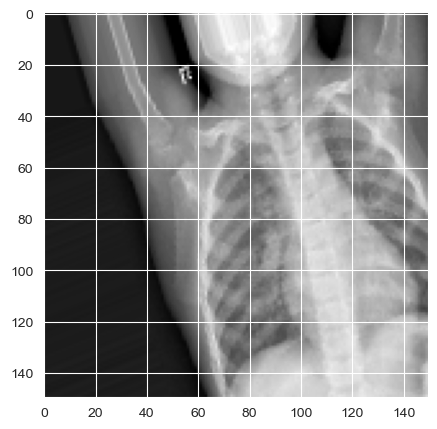

In [12]:
plt.figure(figsize = (5,5))
plt.imshow(augmented_images[0], cmap='gray')

In [13]:
# Ajouter les images augmentées à l'ensemble d'entraînement
augmented_labels = np.ones(len(augmented_images))
X_train = np.concatenate((X_train, augmented_images))
y_train = np.concatenate((y_train, augmented_labels))

In [14]:
# Diviser les données d'entraînement en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Nous effectuons une normalisation en niveaux de gris pour réduire l'effet des différences d'éclairage. De plus, le CNN converge plus rapidement sur des données [0..1] que sur des données [0..255].

In [15]:
# Convertir les données en format approprié pour Keras
x_train = X_train.astype('float32') / 255.
x_val = X_val.astype('float32') / 255.
x_test = X_test.astype('float32')/ 255

In [16]:
# Redimensionner les données pour l'apprentissage profond. 
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_test = x_test.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)

# Augmentation des données sur toute la base de données d'entrainement
**Afin d'éviter le problème de surapprentissage, nous devons agrandir artificiellement notre base de données. Nous pouvons rendre votre ensemble de données existant encore plus grand. L'idée est de modifier les données d'entraînement avec de petites transformations pour reproduire les variations.
Les approches qui modifient les données d'entraînement de manière à changer la représentation du tableau tout en gardant la même étiquette sont connues sous le nom de techniques d'augmentation des données. Certaines augmentations populaires utilisées sont les niveaux de gris, les retournements horizontaux, les retournements verticaux, les recadrages aléatoires, les variations de couleur, les translations, les rotations et bien d'autres encore.
En appliquant seulement quelques-unes de ces transformations à nos données d'entraînement, nous pouvons facilement doubler ou tripler le nombre d'exemples d'entraînement et créer un modèle très robuste.**

In [17]:
# Avec l'augmentation des données pour prévenir le surapprentissage et gérer le déséquilibre dans la base de données

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range = 30,  
        zoom_range = 0.2, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        horizontal_flip = True,  
        vertical_flip=False) 


datagen.fit(x_train)

Pour l'augmentation des données, j'ai choisi de :
1. Faire pivoter aléatoirement certaines images d'entraînement de 30 degrés
2. Zoomer aléatoirement de 20% sur certaines images d'entraînement
3. Décaler aléatoirement les images horizontalement de 10% de la largeur
4. Décaler aléatoirement les images verticalement de 10% de la hauteur
5. Retourner aléatoirement les images horizontalement.
Une fois notre modèle prêt, nous ajustons l'ensemble de données d'entraînement.

In [22]:
#pour éviter les messages de Warnings
import warnings
warnings.filterwarnings('ignore')

# Entraînement du modèle

In [19]:
model = Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' ,
                 activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 150, 150, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 38, 38, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 38, 38, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 38, 38, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46208)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,914,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │              

 Total params: 6,193,729 (23.63 MB)

 Trainable params: 6,192,897 (23.62 MB)

 Non-trainable params: 832 (3.25 KB)

In [29]:
# ajuster dynamiquement le taux d’apprentissage pendant l’entraînement en fonction des performances du modèle sur un ensemble de validation. 
# Cela peut conduire à une meilleure convergence et performance du modèle.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',  
    patience=3,         
    verbose=1, 
    factor=0.2,          
    min_lr=0.00001       
)

In [30]:
# Ajoutez un early stopping pour éviter le overfitting et économiser du temps d’entraînement.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [31]:
# Enregistrer le meilleur modèle pendant la formation en fonction des performances de validation
model_checkpoint = ModelCheckpoint(
    'best_model.keras',  
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [32]:
# apprentissage du modèle
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=20,  
    validation_data=(x_val, y_val),  
    callbacks=[learning_rate_reduction, early_stopping, model_checkpoint],
    verbose=1  
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7217 - loss: 4.1725
Epoch 1: val_loss improved from inf to 9.80782, saving model to best_model.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.7219 - loss: 4.1564 - val_accuracy: 0.5869 - val_loss: 9.8078 - learning_rate: 0.0010
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7652 - loss: 0.5499
Epoch 2: val_loss did not improve from 9.80782
165/165 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.7654 - loss: 0.5495 - val_accuracy: 0.5869 - val_loss: 42.3022 - learning_rate: 0.0010
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8693 - loss: 0.3379
Epoch 3: val_loss improved from 9.80782 to 1.29861, saving model to best_model.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.8693 - loss: 0.3379 - val_accuracy: 0.5847 - val_loss: 1.2986 - learning_rate: 0.0010
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8829 - loss: 0.2906
Epoch 4: val_loss di

In [55]:
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f'Final Training Loss: {train_loss}')
print(f'Final Validation Loss: {val_loss}')
print(f'Final Training Accuracy: {train_accuracy}')
print(f'Final Validation Accuracy: {val_accuracy}')


Final Training Loss: 0.10173076391220093
Final Validation Loss: 0.29410234093666077
Final Training Accuracy: 0.9623860120773315
Final Validation Accuracy: 0.8466210961341858


# Analyse après l'entraînement du modèle

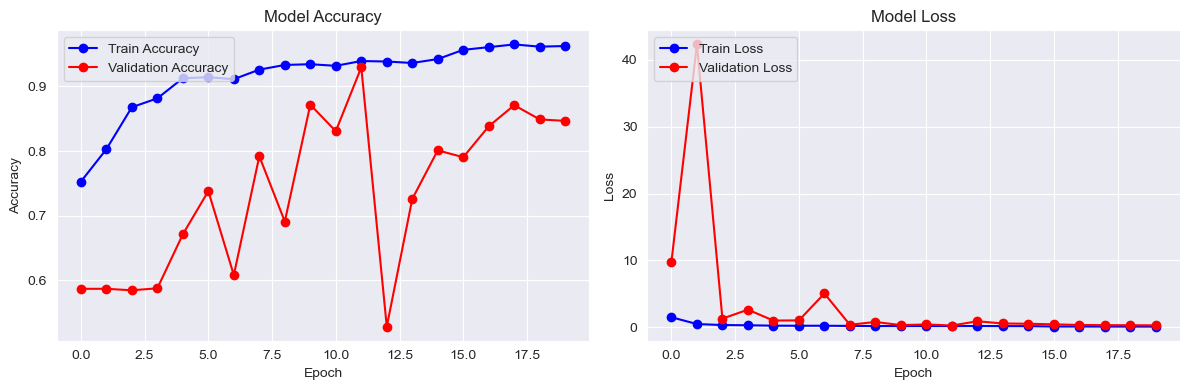

In [34]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'bo-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'bo-', label='Train Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
evalu = model.evaluate(x_test, y_test)
print("Loss du modèle est : " , evalu[0])
print("Accuracy du modèle est : ", evalu[1]*100, "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.9332 - loss: 0.2413
Loss du modèle est :  0.48642152547836304
Accuracy du modèle est :  79.32692170143127 %


In [40]:
y_pred = model.predict(x_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step


In [46]:
y_pred_classes = y_pred > 0.5
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([3110, 2154], dtype=int64))

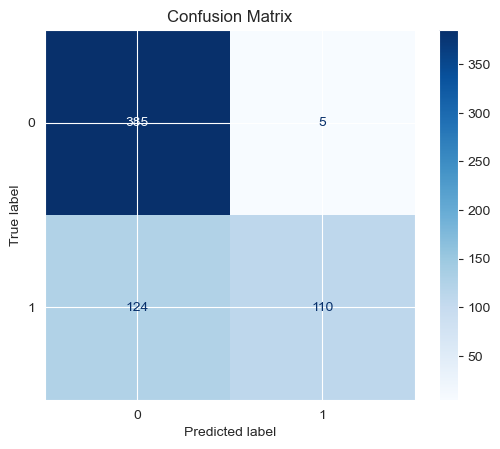

In [47]:
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [48]:
precision_per_class = precision_score(y_test, y_pred_classes, average=None)
print(f'Precision per class: {precision_per_class}')

Precision per class: [0.75638507 0.95652174]


In [49]:
recall_per_class = recall_score(y_test, y_pred_classes, average=None)
print(f'Recall per class: {recall_per_class}')

Recall per class: [0.98717949 0.47008547]


In [50]:
 best_model = load_model('best_model.keras')
f1_per_class = f1_score(y_test, y_pred_classes, average=None)

print(f'F1 score per class: {f1_per_class}')

F1 score per class: [0.85650723 0.63037249]
